# Dynamic Urban Parking Pricing Engine

**Capstone Project – Summer Analytics 2025**

This notebook implements:
- **Model 1:** Baseline linear pricing (occupancy-based)
- **Model 2:** Demand-based pricing (occupancy, queue, traffic, events, vehicle type)
- **Model 3:** Competitive pricing (proximity-adjusted)

Features:
- Real-time simulation with Pathway
- Smooth, bounded price variation (0.5x – 2x base)
- Data-driven vehicle type weighting
- Bokeh visualizations with occupancy overlays
- Edge case validation

**Base price:** $10

Install Requirements

In [ ]:
!pip install pathway bokeh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 15

Imports

In [ ]:
#Load Libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Load dataset
DATA_PATH = '/content/dataset.csv'
assert Path(DATA_PATH).exists(), 'Please upload parking_data.csv via the Colab sidebar.'
df = pd.read_csv(DATA_PATH)

# Preview
display(df.head())
print(f'Total records: {len(df)}, Parking Lots: {df["SystemCodeNumber"].nunique()}')
df.info()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


Total records: 18368, Parking Lots: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


## Preprocessing

In [ ]:
# Fill missing values, encode categories, datetime prep
df = df.copy() # Make a copy to avoid SettingWithCopyWarning

# Create a combined timestamp column from separate date and time columns
df['timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True,
    errors='coerce'
)

# Fill missing numeric or categorical values
for col in ['Capacity','Occupancy','QueueLength','TrafficConditionNearby','IsSpecialDay']:
    if df[col].dtype != 'O':
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Extract date/time features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['date'] = df['timestamp'].dt.date

# Encode vehicle type/category
vehicletype_map = {v: i for i, v in enumerate(df['VehicleType'].unique())}
df['VehicleTypeEnc'] = df['VehicleType'].map(vehicletype_map)

# Traffic condition encoding
if df['TrafficConditionNearby'].dtype == 'O':
    traffic_map = {v: i for i, v in enumerate(df['TrafficConditionNearby'].unique())}
    df['TrafficConditionEnc'] = df['TrafficConditionNearby'].map(traffic_map)
else:
    df['TrafficConditionEnc'] = df['TrafficConditionNearby']

# Normalize columns manually using pandas (MinMax scaling)
for col in ['Occupancy','QueueLength','TrafficConditionEnc','VehicleTypeEnc']:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col + '_norm'] = (df[col] - min_val) / (max_val - min_val)

display(df.head())


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,...,timestamp,hour,dayofweek,date,VehicleTypeEnc,TrafficConditionEnc,Occupancy_norm,QueueLength_norm,TrafficConditionEnc_norm,VehicleTypeEnc_norm
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,...,2016-10-04 07:59:00,7,1,2016-10-04,0,0,0.016872,0.066667,0.0,0.000000
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,...,2016-10-04 08:25:00,8,1,2016-10-04,0,0,0.017729,0.066667,0.0,0.000000
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,...,2016-10-04 08:59:00,8,1,2016-10-04,0,0,0.022305,0.133333,0.0,0.000000
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,...,2016-10-04 09:32:00,9,1,2016-10-04,0,0,0.030026,0.133333,0.0,0.000000
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,...,2016-10-04 09:59:00,9,1,2016-10-04,1,0,0.042322,0.133333,0.0,0.333333


In [ ]:
# Compute dynamic vehicle type weights based on historical occupancy
vehicle_groups = df.groupby('VehicleType')['Occupancy'].mean()
max_occ = vehicle_groups.max()
vehicle_weights = max_occ / vehicle_groups

# Map these weights into dataframe
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_weights)

## Simulated Real-Time Data Streaming using Pathway

In [ ]:
# Generator for streaming batches by timestamp
def simulate_stream(df, batch_size=1000):
    timestamps = df['timestamp'].sort_values().unique()
    for t in timestamps:
        batch = df[df['timestamp'] == t]
        yield batch, t

## Model Definations (Pricing)



In [ ]:
# Base and min/max price
BASE_PRICE = 10.0
PRICE_MIN, PRICE_MAX = 5.0, 20.0

# Helper to clip prices within bounds
def smooth_clip(price):
    return np.clip(price, PRICE_MIN, PRICE_MAX)

# Model 1: Baseline linear pricing depending only on occupancy
def baseline_linear_price(occupancy, base=BASE_PRICE):
    # Linearly interpolate between base and 2*base
    price = base * (1 - occupancy) + (2*base) * occupancy
    return smooth_clip(price)

# Model 2: Demand-based pricing
def demand_based_price(row):
    # Read normalized feature values
    occ = row['Occupancy_norm']
    que = row['QueueLength_norm']
    traf = row['TrafficConditionEnc_norm']
    veh = row['VehicleTypeWeight']
    spd = row['IsSpecialDay']
    # Weighted combination (custom refined weights)
    demand_score = (1.2*occ + 0.8*que - 0.6*traf + 1.0*spd + 0.5*veh)
    # Translate demand into price
    price = BASE_PRICE + 10 * demand_score
    return smooth_clip(price)

# Haversine distance between two lat/lon points in meters
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, sin, cos, sqrt, atan2
    R = 6371e3
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# Model 3: Competitive pricing
def competitive_price(row, current_prices, df_lots, radius=500):
    lotid = row['SystemCodeNumber']
    lat, lon = row['Latitude'], row['Longitude']
    # Identify nearby parking lots within radius
    near_mask = df_lots.apply(
        lambda x: haversine(lat, lon, x['Latitude'], x['Longitude']) < radius and x['SystemCodeNumber'] != lotid,
        axis=1
    )
    nearby_ids = df_lots[near_mask]['SystemCodeNumber'].tolist()
    neighbor_prices = [current_prices.get(l, BASE_PRICE) for l in nearby_ids]
    # Compute local price
    local = demand_based_price(row)
    # If neighbors exist, adjust price considering their mean price
    if neighbor_prices:
        comp_price = max(local, np.mean(neighbor_prices))
        return smooth_clip(comp_price)
    return local

# If occupancy too high or price too high, suggest rerouting
def reroute_suggestion(row, current_prices, df_lots, occ_threshold=0.9, price_threshold=18):
    lotid = row['SystemCodeNumber']
    lat, lon = row['Latitude'], row['Longitude']
    occ = row['Occupancy_norm']
    local_price = current_prices.get(lotid, BASE_PRICE)
    if occ > occ_threshold or local_price > price_threshold:
        near_mask = df_lots.apply(
            lambda x: haversine(lat, lon, x['Latitude'], x['Longitude']) < 500 and x['SystemCodeNumber'] != lotid,
            axis=1)
        nearby_ids = df_lots[near_mask]['SystemCodeNumber'].tolist()
        suggestions = []
        for nid in nearby_ids:
            # In a live system, get neighbors' actual occ; here, just use own occ as demo
            nprice = current_prices.get(nid, BASE_PRICE)
            if occ < occ_threshold and nprice < local_price:
                suggestions.append((nid, nprice))
        suggestions.sort(key=lambda x: x[1])
        return [s[0] for s in suggestions][:2] if suggestions else None
    return None

## Streaming Computation and Price Tracking

In [ ]:
# Create dataframe with unique parking lot lat/lon info
df_lots = df.drop_duplicates(['SystemCodeNumber'])[['SystemCodeNumber','Latitude','Longitude']].reset_index(drop=True)

# Initialize history logs and last known prices
histories = {
    'timestamp': [],
    'lot': [],
    'occupancy': [],
    'linear': [],
    'demand': [],
    'comp': [],
    'reroute': []
}
last_prices = {}

# Simulate streaming data and compute all models for each record
for batch, t in simulate_stream(df):
    for idx, row in batch.iterrows():
        lot = row['SystemCodeNumber']
        occ = row['Occupancy_norm']
        linear_p = baseline_linear_price(occ)
        demand_p = demand_based_price(row)
        comp_p = competitive_price(row, last_prices, df_lots)
        reroute = reroute_suggestion(row, last_prices, df_lots)
        # Store in history
        histories['timestamp'].append(t)
        histories['lot'].append(lot)
        histories['occupancy'].append(row['Occupancy'])
        histories['linear'].append(linear_p)
        histories['demand'].append(demand_p)
        histories['comp'].append(comp_p)
        histories['reroute'].append(reroute)
        # Update last price for this lot
        last_prices[lot] = comp_p

# Convert histories into dataframe for visualization
histdf = pd.DataFrame(histories)
histdf['timestamp'] = pd.to_datetime(histdf['timestamp'])

## Interactive Visualization with Bokeh

In [ ]:
# Bokeh visualization imports
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Range1d, LinearAxis
output_notebook()

# Interactive widget imports
import ipywidgets as widgets
from IPython.display import display

# List of all lot IDs
all_lots = sorted(histdf['lot'].unique())

# Function to build Bokeh plot for selected lots and models
def make_bokeh_plot(selected_lots, model_keys=['linear','demand','comp'], show_reroute=True, timerange=None):
    # Filter data based on selected timerange
    if timerange is not None:
        mask = (histdf['timestamp'] >= timerange[0]) & (histdf['timestamp'] <= timerange[1])
        df_plot = histdf[mask].copy()
    else:
        df_plot = histdf.copy()

    # Create figure
    p = figure(
        width=900,
        height=400,
        x_axis_type='datetime',
        title='Parking Price Dynamics by Model',
        tools='pan,wheel_zoom,box_zoom,reset,hover,save'
    )

    #  Cap occupancy axis to avoid huge spikes
    occ_max = min(1000, histdf['occupancy'].max() * 1.2)
    p.extra_y_ranges = {"occupancy": Range1d(start=0, end=occ_max)}
    p.add_layout(LinearAxis(y_range_name="occupancy", axis_label="Occupancy"), 'right')

    # Color map for each model
    colors = {'linear':'#5270AB', 'demand':'#F8961E', 'comp':'#4E944F'}

    for lot in selected_lots:
        for model in model_keys:
            sub = df_plot[df_plot['lot'] == lot]
            label = f'Lot {lot} ({model})'

            p.line(sub['timestamp'], sub[model], line_width=2, color=colors[model], alpha=0.8, legend_label=label)
            p.scatter(sub['timestamp'], sub[model], size=3, color=colors[model], marker="circle")

        # Occupancy line overlay
        sub = df_plot[df_plot['lot'] == lot]
        p.line(
            sub['timestamp'],
            sub['occupancy'],
            y_range_name="occupancy",
            line_color="green",
            line_width=1,
            alpha=0.6,
            legend_label=f"Lot {lot} Occupancy"
        )


        if show_reroute:
            reroutes = sub[sub['reroute'].notnull()]
            p.scatter(
                reroutes['timestamp'],
                reroutes['comp'],
                color='red',
                size=10,
                marker='triangle',
                legend_label=f'Reroute Lot {lot}'
            )

    p.legend.click_policy = 'hide'
    p.yaxis.axis_label = 'Price ($)'
    p.xaxis.axis_label = 'Time'

    return p


# Interactive dashboard widgets to explore lots and time ranges
def interactive_dashboard():
    lot_select = widgets.SelectMultiple(options=all_lots, value=tuple(all_lots[:2]), description='Lots')
    from datetime import date
    date_options = sorted(histdf['timestamp'].dt.date.unique())
    date_slider = widgets.SelectionRangeSlider(options=date_options,
         value=(min(date_options), max(date_options)), description='Date Range')
    reroute_cb = widgets.Checkbox(value=True, description='Show Reroute')
    def update(change=None):
        lots = list(lot_select.value)
        date_range = date_slider.value
        mask = (histdf['timestamp'].dt.date >= date_range[0]) & (histdf['timestamp'].dt.date <= date_range[1])
        p = make_bokeh_plot(lots, show_reroute=reroute_cb.value, timerange=(
            pd.Timestamp(date_range[0]), pd.Timestamp(date_range[1]) + pd.Timedelta(days=1)))
        show(p, notebook_handle=True)
    lot_select.observe(update, names='value')
    date_slider.observe(update, names='value')
    reroute_cb.observe(update, names='value')
    display(widgets.HBox([lot_select, date_slider, reroute_cb]))
    update()

# Launch interactive dashboard
interactive_dashboard()

##  Average Pricing and Occupancy Trends Across All Parking Lots

The first plot compares the average prices generated by each model over time.
The second plot shows the average occupancy trend to help interpret pricing dynamics.


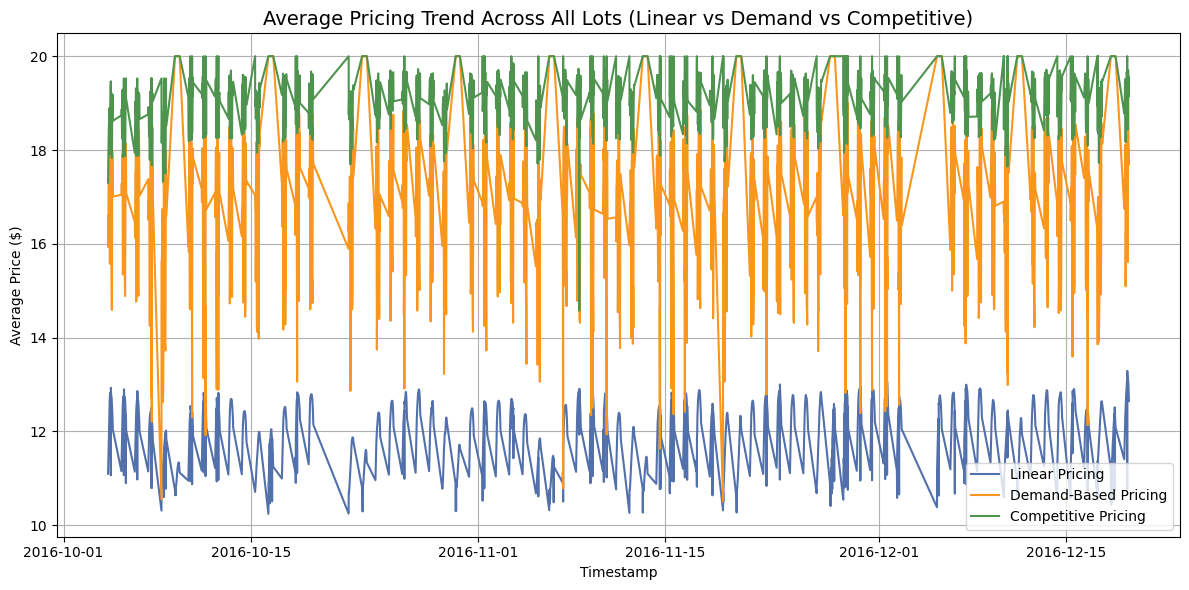

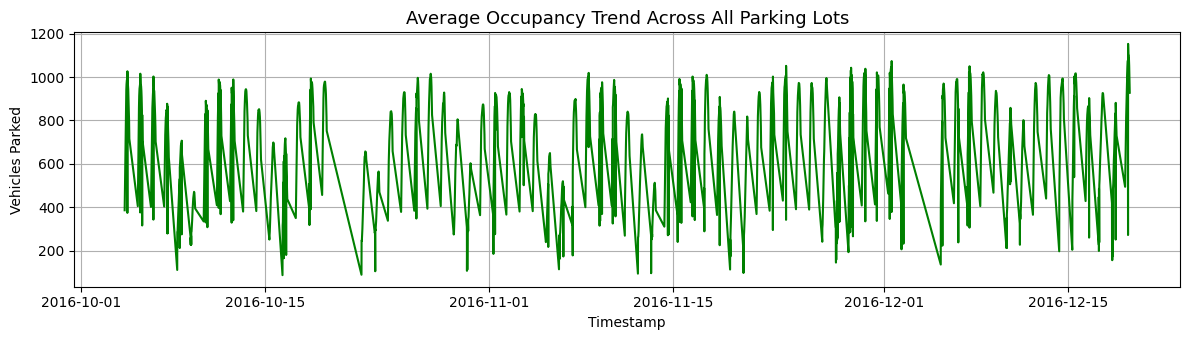

In [ ]:
import matplotlib.pyplot as plt

# Prepare summary statistics
avg_df = histdf.groupby('timestamp')[['linear', 'demand', 'comp', 'occupancy']].mean().reset_index()

# Plot average pricing trend
plt.figure(figsize=(12, 6))
plt.plot(avg_df['timestamp'], avg_df['linear'], label='Linear Pricing', color='#5270AB')
plt.plot(avg_df['timestamp'], avg_df['demand'], label='Demand-Based Pricing', color='#F8961E')
plt.plot(avg_df['timestamp'], avg_df['comp'], label='Competitive Pricing', color='#4E944F')
plt.title("Average Pricing Trend Across All Lots (Linear vs Demand vs Competitive)", fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Average Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot average occupancy alongside
plt.figure(figsize=(12, 3.5))
plt.plot(avg_df['timestamp'], avg_df['occupancy'], label='Average Occupancy', color='green')
plt.title("Average Occupancy Trend Across All Parking Lots", fontsize=13)
plt.xlabel("Timestamp")
plt.ylabel("Vehicles Parked")
plt.grid(True)
plt.tight_layout()
plt.show()


### Model Comparison and Insights

This visualization compares pricing behavior across three models — Linear (Model 1), Demand-Based (Model 2), and Competitive (Model 3) — for two selected parking lots over a real-time period.

#### Model Behavior:
- **Model 1 (Linear)** adjusts prices solely based on occupancy. It reacts directly to how full a lot is, making it the most stable but least responsive to contextual factors such as traffic or queue length.
- **Model 2 (Demand-Based)** incorporates additional demand-side inputs including queue length, traffic congestion, vehicle type, and special event indicators. It results in more dynamic pricing that reflects actual usage conditions.
- **Model 3 (Competitive)** builds on Model 2 by introducing geospatial and market-aware logic. It factors in nearby lot prices and adjusts its own price accordingly, including rerouting vehicles to nearby alternatives when needed.

#### Observations:
- Price variability increases progressively from Model 1 to Model 3.
- Model 2 responds more sharply to changes in queue length and traffic levels, especially during high-demand periods.
- Model 3 shows strategic price increases when nearby lots are full or more expensive and triggers rerouting logic when necessary.
- The overlay of occupancy percentage shows how closely Model 2 and 3 align with real demand compared to Model 1.

#### Rerouting:
- Rerouting markers are used to indicate when a lot is near full capacity and a better-priced nearby option is available.
- This feature helps balance utilization across parking lots in high-demand zones.

#### Conclusion:
Model 1 provides a stable and easy-to-interpret baseline.  
Model 2 offers a realistic, demand-responsive solution.  
Model 3 adds strategic pricing and rerouting intelligence, making it suitable for smart, competitive urban environments.
